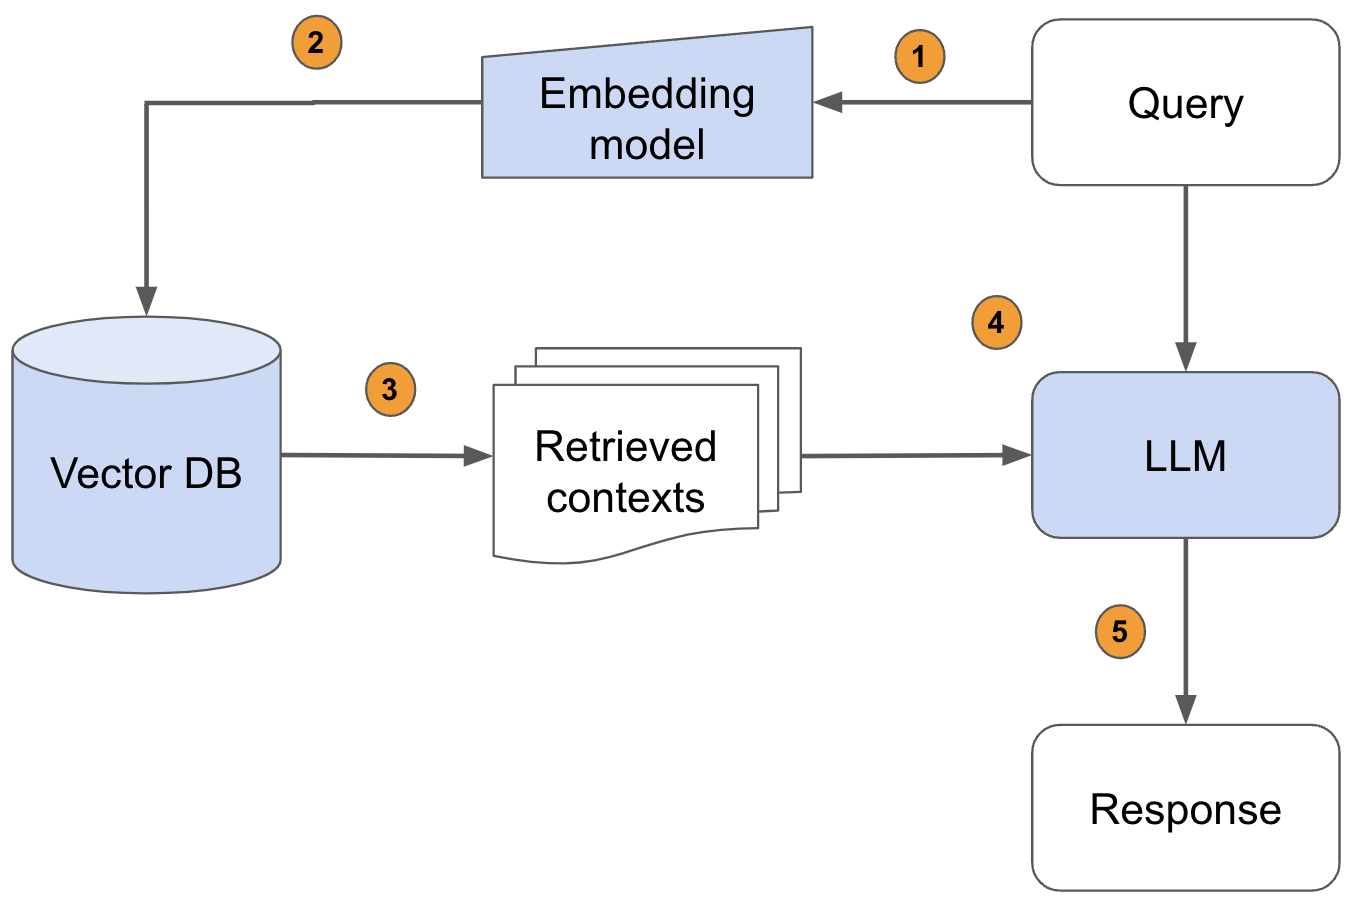

# Custom Evaluation with LlamaIndex

In this notebook, we evaluate 3 different embedding models: 
1. proprietary OpenAI embedding,
2. open source `BAAI/bge-small-en`, and
3. our finetuned embedding model.

We consider 2 evaluation approaches:
1. a simple custom **hit rate** metric
2. using `InformationRetrievalEvaluator` from sentence_transformers

We show that finetuning on synthetic (LLM-generated) dataset significantly improve upon an opensource embedding model.

In [ ]:
import json
from tqdm.notebook import tqdm
import pandas as pd
import torch

from llama_index.core import ServiceContext, VectorStoreIndex
from llama_index.core.schema import TextNode

### Load data

First, let's load the synthetic dataset we automatically generated from our corpus (without having access to any labellers).

In [2]:
DATA_PATH = "/home/75y/data_ragMimic/data/"

In [3]:
TRAIN_DATASET_FPATH = DATA_PATH+'train_dataset.json'
VAL_DATASET_FPATH = DATA_PATH+'val_dataset.json'

In [4]:
with open(TRAIN_DATASET_FPATH, 'r+') as f:
    train_dataset = json.load(f)

with open(VAL_DATASET_FPATH, 'r+') as f:
    val_dataset = json.load(f)

### Define eval function

**Option 1**: We use a simple **hit rate** metric for evaluation:
* for each (query, relevant_doc) pair,
* we retrieve top-k documents with the query,  and 
* it's a **hit** if the results contain the relevant_doc.

This approach is very simple and intuitive, and we can apply it to both the proprietary OpenAI embedding as well as our open source and fine-tuned embedding models.

In [5]:
def evaluate(
    dataset,
    embed_model,
    top_k=5,
    verbose=False,
):
    corpus = dataset['corpus']
    queries = dataset['queries']
    relevant_docs = dataset['relevant_docs']

    model_name_or_path = "mistralai/Mistral-7B-Instruct-v0.1"
    llm = HuggingFaceLLM(
      context_window=4096,
      max_new_tokens=2048,
      generate_kwargs={'temperature': 0.2, 'do_sample': True, 'top_p': 0.95, 'top_k': 40, 'repetition_penalty': 1.1},
      tokenizer_name=model_name_or_path,
      model_name=model_name_or_path,
      device_map='auto',
      model_kwargs={'torch_dtype': torch.float16},
    )

    service_context = ServiceContext.from_defaults(
      chunk_size=1024,
      chunk_overlap=256,
      llm=llm,
      embed_model=embed_model,
    )
    
    nodes = [TextNode(id_=id_, text=text) for id_, text in corpus.items()] 
    index = VectorStoreIndex(
        nodes, 
        service_context=service_context, 
        show_progress=True
    )
    retriever = index.as_retriever(similarity_top_k=top_k)

    eval_results = []
    for query_id, query in tqdm(queries.items()):
        retrieved_nodes = retriever.retrieve(query)
        retrieved_ids = [node.node.node_id for node in retrieved_nodes]
        expected_id = relevant_docs[query_id][0]
        is_hit = expected_id in retrieved_ids  # assume 1 relevant doc
        
        eval_result = {
            'is_hit': is_hit,
            'retrieved': retrieved_ids,
            'expected': expected_id,
            'query': query_id,
        }
        eval_results.append(eval_result)
    return eval_results

**Option 2**: We use the `InformationRetrievalEvaluator` from sentence_transformers.

This provides a more comprehensive suite of metrics, but we can only run it against the sentencetransformers compatible models (open source and our finetuned model, *not* the OpenAI embedding model).

In [6]:
from sentence_transformers.evaluation import InformationRetrievalEvaluator
from sentence_transformers import SentenceTransformer
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader
from llama_index.llms.huggingface import HuggingFaceLLM
from llama_index.embeddings.huggingface import HuggingFaceEmbedding 

def evaluate_st(
    dataset,
    model_id,
    name,
):
    corpus = dataset['corpus']
    queries = dataset['queries']
    relevant_docs = dataset['relevant_docs']

    evaluator = InformationRetrievalEvaluator(queries, corpus, relevant_docs, name=name)
    model = SentenceTransformer(model_id)
    return evaluator(model, output_path='results/')

### Run Evals

### BAAI/bge-small-en

In [7]:
# embedding model
bge = HuggingFaceEmbedding(model_name='BAAI/bge-large-en-v1.5')
bge_val_results = evaluate(val_dataset, bge)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/tmp/ipykernel_2649458/890256498.py:22: DeprecationWarning: Call to deprecated class method from_defaults. (ServiceContext is deprecated, please use `llama_index.settings.Settings` instead.) -- Deprecated since version 0.10.0.
  service_context = ServiceContext.from_defaults(


Generating embeddings:   0%|          | 0/865 [00:00<?, ?it/s]

  0%|          | 0/1830 [00:00<?, ?it/s]

In [8]:
# import sys
# !{sys.executable} -m pip install optimum
# !{sys.executable} -m pip install auto-gptq
# !{sys.executable} -m pip install llama-index-embeddings-huggingface
# !{sys.executable} -m pip install llama-index-llms-huggingface


In [9]:
df_bge = pd.DataFrame(bge_val_results)

In [10]:
hit_rate_bge = df_bge['is_hit'].mean()
hit_rate_bge

0.12021857923497267

In [11]:
evaluate_st(val_dataset, "BAAI/bge-large-en-v1.5", name='bge')

0.09838071449499144

### Finetuned

In [12]:
finetuned = HuggingFaceEmbedding(model_name='exp_finetune')
val_results_finetuned = evaluate(val_dataset, finetuned)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/tmp/ipykernel_2649458/890256498.py:22: DeprecationWarning: Call to deprecated class method from_defaults. (ServiceContext is deprecated, please use `llama_index.settings.Settings` instead.) -- Deprecated since version 0.10.0.
  service_context = ServiceContext.from_defaults(


Generating embeddings:   0%|          | 0/865 [00:00<?, ?it/s]

  0%|          | 0/1830 [00:00<?, ?it/s]

In [13]:
df_finetuned = pd.DataFrame(val_results_finetuned)

In [14]:
hit_rate_finetuned = df_finetuned['is_hit'].mean()
hit_rate_finetuned

0.2278688524590164

In [15]:
evaluate_st(val_dataset, "exp_finetune", name='finetuned')

0.16727882124527382

### Summary of Results

#### Hit rate

In [16]:
df_bge['model'] = 'bge'
df_finetuned['model'] = 'fine_tuned'

We can see that fine-tuning our small open-source embedding model drastically improve its retrieval quality (even approaching the quality of the proprietary OpenAI embedding)!

In [17]:
df_all = pd.concat([df_bge, df_finetuned])
df_all.groupby('model').mean('is_hit')

,is_hit
model,
bge,0.120219
fine_tuned,0.227869


### InformationRetrievalEvaluator

In [18]:
df_st_bge = pd.read_csv('results/Information-Retrieval_evaluation_bge_results.csv')
df_st_finetuned = pd.read_csv('results/Information-Retrieval_evaluation_finetuned_results.csv')

We can see that embedding finetuning improves metrics consistently across the suite of eval metrics 

In [19]:
df_st_bge['model'] = 'bge'
df_st_finetuned['model'] = 'fine_tuned'
df_st_all = pd.concat([df_st_bge, df_st_finetuned])
df_st_all = df_st_all.set_index('model')
df_st_all

,epoch,steps,cos_sim-Accuracy@1,cos_sim-Accuracy@3,cos_sim-Accuracy@5,cos_sim-Accuracy@10,cos_sim-Precision@1,cos_sim-Recall@1,cos_sim-Precision@3,cos_sim-Recall@3,...,dot_score-Recall@1,dot_score-Precision@3,dot_score-Recall@3,dot_score-Precision@5,dot_score-Recall@5,dot_score-Precision@10,dot_score-Recall@10,dot_score-MRR@10,dot_score-NDCG@10,dot_score-MAP@100
model,,,,,,,,,,,,,,,,,,,,,
bge,-1,-1,0.076482,0.131931,0.162524,0.209369,0.076482,0.076482,0.043977,0.131931,...,0.076482,0.043977,0.131931,0.032505,0.162524,0.020937,0.209369,0.114267,0.136742,0.125383
bge,-1,-1,0.060109,0.103279,0.133333,0.169399,0.060109,0.060109,0.034426,0.103279,...,0.060109,0.034426,0.103279,0.026667,0.133333,0.016940,0.169399,0.090310,0.109003,0.098381
bge,-1,-1,0.060109,0.103279,0.133333,0.169399,0.060109,0.060109,0.034426,0.103279,...,0.060109,0.034426,0.103279,0.026667,0.133333,0.016940,0.169399,0.090310,0.109003,0.098381
fine_tuned,-1,-1,0.110899,0.185468,0.224665,0.298279,0.110899,0.110899,0.061823,0.185468,...,0.110899,0.061823,0.185468,0.044933,0.224665,0.029828,0.298279,0.162643,0.194498,0.179815
fine_tuned,-1,-1,0.119672,0.198907,0.243716,0.334426,0.119672,0.119672,0.066302,0.198907,...,0.119672,0.066302,0.198907,0.048743,0.243716,0.033443,0.334426,0.176507,0.213372,0.190975
fine_tuned,-1,-1,0.093989,0.173770,0.227869,0.310383,0.093989,0.093989,0.057923,0.173770,...,0.093989,0.057923,0.173770,0.045574,0.227869,0.031038,0.310383,0.152328,0.189464,0.167279
